In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
import pprint

import neural_network_lyapunov
import neural_network_lyapunov.relu_system as relu_system
import neural_network_lyapunov.lyapunov as lyapunov
import neural_network_lyapunov.encoders as encoders
import neural_network_lyapunov.pybullet_data_generation as pybullet_data_generation
import neural_network_lyapunov.dynamics_learning as dynamics_learning
import neural_network_lyapunov.utils as utils

## Loading options

In [49]:
folder = "experiments/cubes"
variant = "unstable"
# variant = "stable_samples"
# variant = "stable"

sys.path.insert(0, os.path.join(os.path.dirname(neural_network_lyapunov.__file__), "..", "notebooks", folder))
import options
opt = dynamics_learning.DynamicsLearningOptions(options.default)
opt.set_options(options.variants[variant])

pp = pprint.PrettyPrinter()
pp.pprint(opt.options)

{'V_eps': 0.0,
 'V_lambda': 0.0,
 'batch_size': 50,
 'camera_eye_position': [0, -0.5, 0.15],
 'camera_target_position': [0, 0, 0.1],
 'camera_up_vector': [0, 0, 1],
 'dataset_N': 5,
 'dataset_dt': 0.1,
 'dataset_noise': 0.1,
 'dataset_num_rollouts': 25,
 'dataset_num_val_rollouts': 10,
 'dataset_x_lo': tensor([-0.1000,  0.0000,  0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000], dtype=torch.float64),
 'dataset_x_up': tensor([0.1000, 0.0000, 0.1500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], dtype=torch.float64),
 'decoded_equilibrium_loss_weight': 0.0,
 'decoder_class': <class 'neural_network_lyapunov.encoders.LinearDecoder1'>,
 'device': 'cpu',
 'dtype': torch.float64,
 'dyn_nn_width': None,
 'encoder_class': <class 'neural_network_lyapunov.encoders.LinearEncoder1'>,
 'grayscale': False,
 'image_height': 72,
 'image_width': 72,
 'joint_space': False,
 'kl_loss_weight': 0.001,
 'latent_dyn_nn_width': (

## Generating data

In [6]:
pbsg = pybullet_data_generation.PybulletSampleGenerator(opt.world_cb, opt.joint_space,
                                                        image_width=opt.image_width, image_height=opt.image_height,
                                                        grayscale=opt.grayscale,
                                                        camera_eye_position=opt.camera_eye_position,
                                                        camera_target_position=opt.camera_target_position,
                                                        camera_up_vector=opt.camera_up_vector,
                                                        dtype=opt.dtype)

In [12]:
x_data, x_next_data, X_data, X_next_data = pbsg.generate_dataset(
    opt.dataset_x_lo, opt.dataset_x_up, opt.dataset_dt, opt.dataset_N, opt.dataset_num_rollouts)

x_val, x_next_val, X_val, X_next_val = pbsg.generate_dataset(
    opt.dataset_x_lo, opt.dataset_x_up, opt.dataset_dt, opt.dataset_N, opt.dataset_num_val_rollouts)

# adding noise to training data
x_data = pybullet_data_generation.add_noise(x_data, opt.dataset_noise)
x_next_data = pybullet_data_generation.add_noise(x_next_data, opt.dataset_noise)

X_data = torch.clamp(pybullet_data_generation.add_noise(X_data, opt.dataset_noise), 0, 1)
X_next_data = torch.clamp(pybullet_data_generation.add_noise(X_next_data, opt.dataset_noise), 0, 1)

In [50]:
x_train_dataloader = pybullet_data_generation.get_dataloader(x_data, x_next_data, opt.batch_size)
x_validation_dataloader = pybullet_data_generation.get_dataloader(x_val, x_next_val, opt.batch_size)
X_train_dataloader = pybullet_data_generation.get_dataloader(X_data, X_next_data, opt.batch_size)
X_validation_dataloader = pybullet_data_generation.get_dataloader(X_val, X_next_val, opt.batch_size)

In [14]:
x_long_horizon_rollouts_x0, _, _, _ = pbsg.generate_dataset(
    opt.dataset_x_lo, opt.dataset_x_up, opt.dataset_dt, 1, opt.long_horizon_num_val_rollouts)
x_long_horizon_rollouts, X_long_horizon_rollouts = pbsg.data_to_rollouts(
    x_long_horizon_rollouts_x0, opt.dataset_dt, opt.long_horizon_N)

In [51]:
torch.save(x_data, os.path.join(folder, "x_data"))
torch.save(x_next_data, os.path.join(folder, "x_next_data"))
torch.save(X_data, os.path.join(folder, "X_data"))
torch.save(X_next_data, os.path.join(folder, "X_next_data"))
torch.save(x_data, os.path.join(folder, "x_val"))
torch.save(x_next_data, os.path.join(folder, "x_next_val"))
torch.save(X_data, os.path.join(folder, "X_val"))
torch.save(X_next_data, os.path.join(folder, "X_next_val"))
torch.save(x_long_horizon_rollouts, os.path.join(folder, "x_long_horizon_rollouts"))
torch.save(X_long_horizon_rollouts, os.path.join(folder, "X_long_horizon_rollouts"))

In [ ]:
x_data = torch.load(os.path.join(folder, "x_data"))
x_next_data = torch.load(os.path.join(folder, "x_next_data"))
X_data = torch.load(os.path.join(folder, "X_data"))
X_next_data = torch.load(os.path.join(folder, "X_next_data"))
x_val = torch.load(os.path.join(folder, "x_val"))
x_next_val = torch.load(os.path.join(folder, "x_next_val"))
X_val = torch.load(os.path.join(folder, "X_val"))
X_next_val = torch.load(os.path.join(folder, "X_next_val"))
x_long_horizon_rollouts = torch.load(os.path.join(folder, "x_long_horizon_rollouts"))
X_long_horizon_rollouts = torch.load(os.path.join(folder, "X_long_horizon_rollouts"))

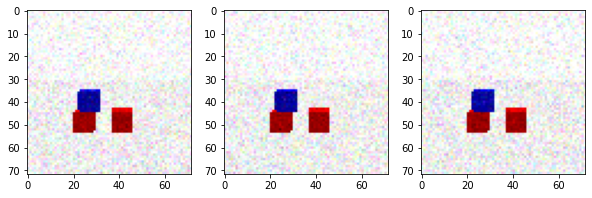

In [30]:
# plot some random sample
i = np.random.choice(X_data.shape[0], 1)[0]
pybullet_data_generation.show_sample(X_data[i,:], X_next_data[i,:])

In [ ]:
# plot some random rollout
i = np.random.choice(len(X_long_horizon_rollouts), 1)[0]
for n in range(X_long_horizon_rollouts[i].shape[0]):
    pybullet_data_generation.show_sample(X_long_horizon_rollouts[i][n, :])

In [31]:
((X_data.shape[0]/opt.batch_size))

5.0

## Learning in state space

In [ ]:
dyn_nn_model = utils.setup_relu(opt.dyn_nn_width, dtype=opt.dtype)
lyap_nn_model = utils.setup_relu(opt.lyap_nn_width, dtype=opt.dtype)

relu_sys = relu_system.AutonomousResidualReLUSystemGivenEquilibrium(opt.dtype, opt.x_lo_stable, opt.x_up_stable,
                                                                    dyn_nn_model, opt.x_equilibrium)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)

dyn_learner = dynamics_learning.StateSpaceDynamicsLearning(x_train_dataloader, x_validation_dataloader, lyap, opt)

In [ ]:
# see how long verification takes
start = time.time()
loss = dyn_learner.lyapunov_loss()
end = time.time()
print(end - start)

start = time.time()
loss[0].backward()
loss[1].backward()
end = time.time()
print(end - start)

In [ ]:
opt.set_option('lyap_loss_freq', 0)

In [ ]:
opt.set_option('lyap_loss_freq', 10)

In [ ]:
dyn_learner.train(10000, validate=True, device=opt.device, save_rate=10, save_path=os.path.join(folder, variant))

In [ ]:
# i = np.random.choice(x_data.shape[0], 1)[0]
# x0 = x_data[i, :]
i = np.random.choice(x_val.shape[0], 1)[0]
x0 = x_val[i, :]
x_traj, V_traj = dyn_learner.rollout(x0, opt.long_horizon_N)
x_traj_exp, _ = pbsg.generate_rollout(x0, opt.dataset_dt, opt.long_horizon_N)
for j in range(x_traj.shape[1]):
    plt.plot(x_traj[:, j])
    plt.plot(x_traj_exp[:, j], ':')
    plt.legend(['predicted', 'expected'])
    plt.show()
plt.plot(V_traj)
plt.show()

## Learning in image space

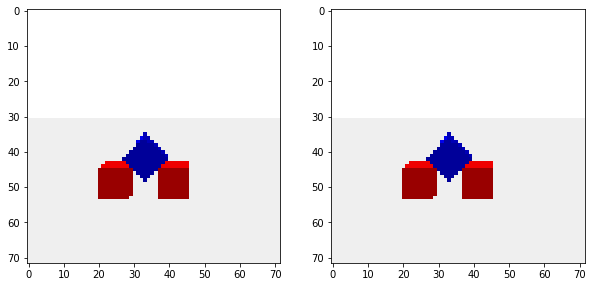

In [33]:
x_data_equ, X_data_equ = pbsg.generate_rollout(opt.x_equilibrium, opt.dataset_dt, opt.long_horizon_N)
X_equilibrium = torch.cat([X_data_equ[-2, :], X_data_equ[-1, :]], dim=0)
pybullet_data_generation.show_sample(X_equilibrium)

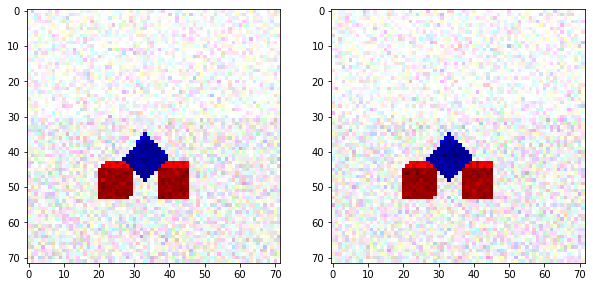

In [34]:
X_equilibrium = torch.clamp(
    pybullet_data_generation.add_noise(X_equilibrium.unsqueeze(0), opt.dataset_noise)[0, :], 0, 1)
pybullet_data_generation.show_sample(X_equilibrium)

In [52]:
dyn_nn_model = utils.setup_relu(opt.latent_dyn_nn_width, dtype=opt.dtype)
lyap_nn_model = utils.setup_relu(opt.latent_lyap_nn_width, dtype=opt.dtype)

relu_sys = relu_system.AutonomousResidualReLUSystemGivenEquilibrium(opt.dtype, opt.z_lo_stable, opt.z_up_stable,
                                                                    dyn_nn_model, opt.z_equilibrium)
lyap = lyapunov.LyapunovDiscreteTimeHybridSystem(relu_sys, lyap_nn_model)

encoder = opt.encoder_class(opt.z_dim, opt.image_width, opt.image_height, opt.grayscale)
decoder = opt.decoder_class(opt.z_dim, opt.image_width, opt.image_height, opt.grayscale)

dyn_learner = dynamics_learning.LatentSpaceDynamicsLearning(X_train_dataloader, X_validation_dataloader,
                                                            lyap, opt, encoder, decoder,
                                                            decoded_equilibrium=X_equilibrium)

In [36]:
dyn_learner.lyap.system.step_forward(dyn_learner.lyap.system.x_equilibrium)

tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float64, grad_fn=<AddBackward0>)

In [37]:
# see how long verification takes
start = time.time()
loss = dyn_learner.lyapunov_loss()
end = time.time()
print(end - start)

start = time.time()
loss[0].backward()
loss[1].backward()
end = time.time()
print(end - start)

Using license file /Users/blandry/gurobi.lic
Academic license - for non-commercial use only
0.7063288688659668
1.1237249374389648


In [ ]:
opt.set_option('lyap_loss_freq', 0)

In [ ]:
opt.set_option('lyap_loss_freq', 10)

In [109]:
# train the encoder-dynamics-decoder
dyn_learner.train(100, validate=True, device=opt.device, save_rate=5, save_path=os.path.join(folder, variant))

/usr/local/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


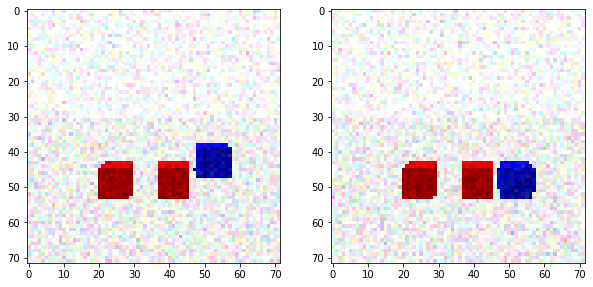

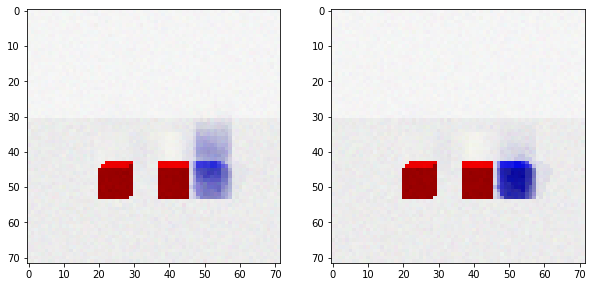

tensor([[-1.2407e-01, -4.6183e-02, -7.5360e-02, -8.9996e-02, -1.5528e-03,
         -2.0832e+00]], dtype=torch.float64, grad_fn=<SliceBackward>)
tensor([[-0.6273,  0.9222,  1.0629,  2.8605, -1.1759, -2.4404]],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [117]:
# plot some encoding-decoding
i = np.random.choice(X_data.shape[0], 1)[0]
pybullet_data_generation.show_sample(X_data[i,:])
X_decoded, _, z_mu, _, z_next = dyn_learner.vae_forward(X_data[i,:].unsqueeze(0))
X_decoded = X_decoded.squeeze()
pybullet_data_generation.show_sample(X_decoded)
print(z_mu)
print(z_next)

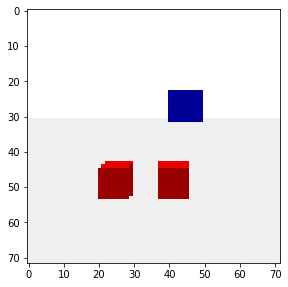

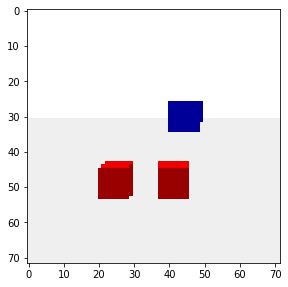

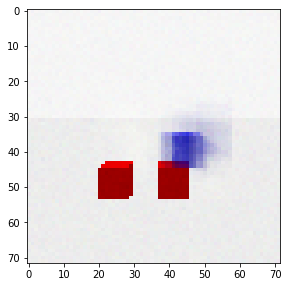

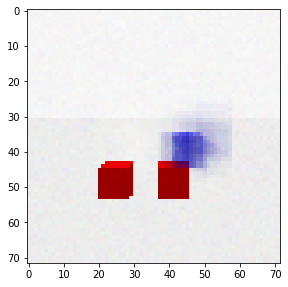

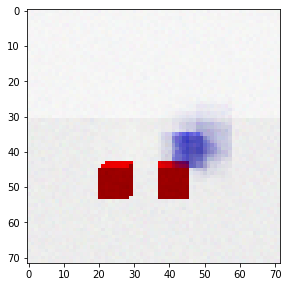

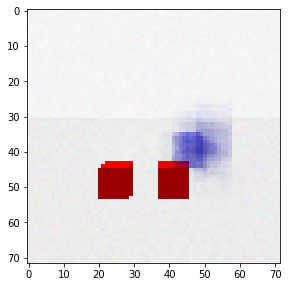

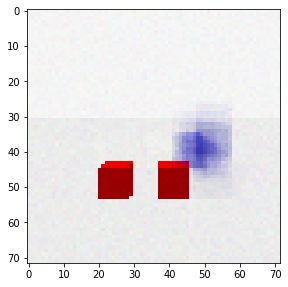

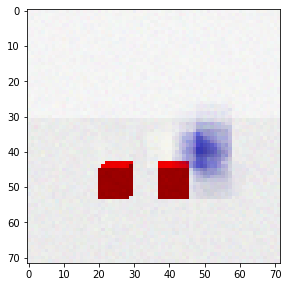

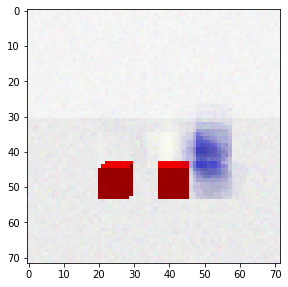

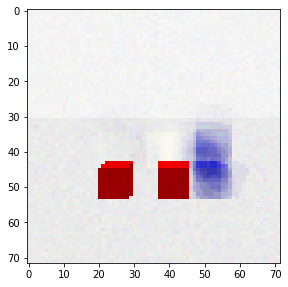

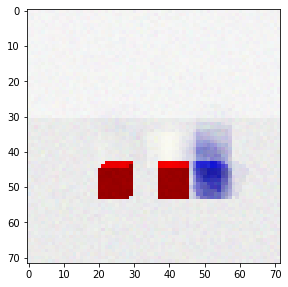

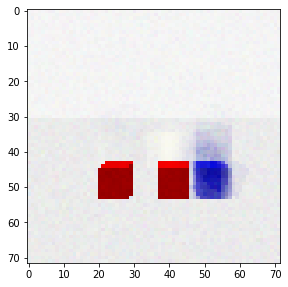

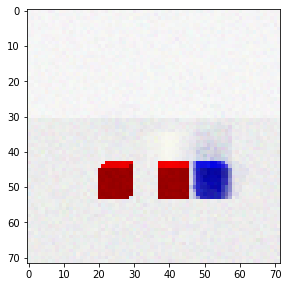

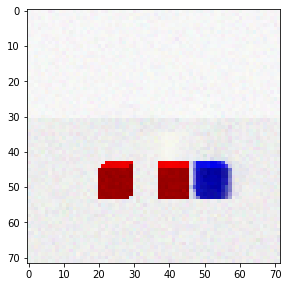

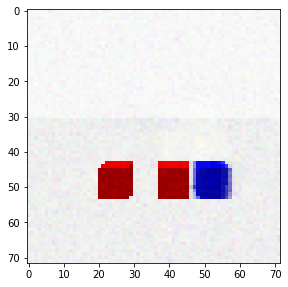

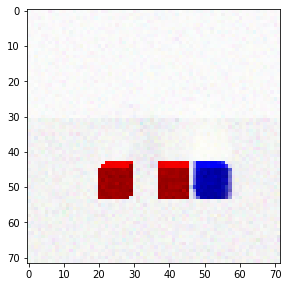

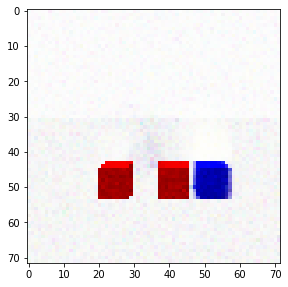

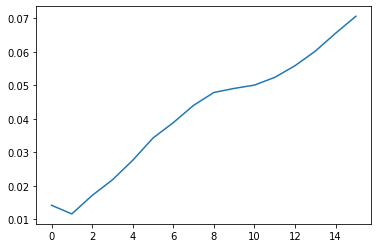

tensor([[-0.0442, -0.0747, -0.0969, -0.3251, -0.0712, -0.4319],
        [-0.1477,  0.1666,  0.2541,  0.4338, -0.0208, -0.5214],
        [-0.1914,  0.2409,  0.3126,  0.5741,  0.0571, -0.5971],
        [-0.2375,  0.3225,  0.3562,  0.7057,  0.1278, -0.6856],
        [-0.2923,  0.4235,  0.4083,  0.8810,  0.1968, -0.7878],
        [-0.3601,  0.5475,  0.4738,  1.1139,  0.2663, -0.9075],
        [-0.4440,  0.6972,  0.5543,  1.4116,  0.3365, -1.0476],
        [-0.5455,  0.8768,  0.6500,  1.7805,  0.4063, -1.2117],
        [-0.6636,  1.0961,  0.7619,  2.2302,  0.4722, -1.4054],
        [-0.8026,  1.3564,  0.9023,  2.7775,  0.5492, -1.6308],
        [-0.9896,  1.6697,  1.0769,  3.4340,  0.6381, -1.8988],
        [-1.2369,  2.0480,  1.2908,  4.2140,  0.7282, -2.2187],
        [-1.5615,  2.4819,  1.5455,  5.1241,  0.8363, -2.5898],
        [-1.9770,  2.9782,  1.8456,  6.1851,  0.9676, -3.0184],
        [-2.4965,  3.5513,  2.1991,  7.4268,  1.1247, -3.5159],
        [-3.1366,  4.2173,  2.6165,  8.8

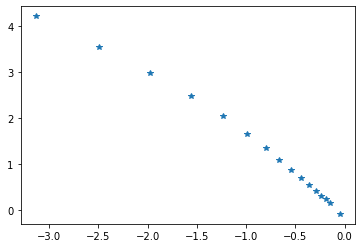

In [121]:
# Same rollout from learned model
i = np.random.choice(x_data.shape[0], 1)[0]
x_traj, X_traj = pbsg.generate_rollout(x_data[i, :], opt.dataset_dt, opt.dataset_N)
X_traj_pred, V_traj_pred, z_traj_pred = dyn_learner.rollout(
    torch.cat([X_traj[0, :], X_traj[1, :]], dim=0), opt.dataset_N*3, decode_intermediate=False)
for n in range(X_traj_pred.shape[0]):
    pybullet_data_generation.show_sample(X_traj_pred[n, :])

plt.plot(V_traj_pred)
plt.show()
print(z_traj_pred)
plt.plot(z_traj_pred[:,0], z_traj_pred[:,1], "*")
plt.show()

In [ ]:
# plot the same rollout but from the real system
for n in range(X_traj.shape[0]):
    pybullet_data_generation.show_sample(X_traj[n, :])

In [ ]:
# plotting the equilibrium
z_equ_decoded = dyn_learner.decoder.forward(dyn_learner.lyap.system.x_equilibrium.unsqueeze(0))[0, :]
pybullet_data_generation.show_sample(z_equ_decoded)